# Lettura Dataset

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ast
import scipy.stats as stats
import plotly.express as px

In [2]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [3]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import SilhouetteVisualizer
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import NearestNeighbors

In [4]:
# Forza la lettura di 'fast_moves' e 'charged_moves' come stringhe
converters = {
    'fast_moves': str,
    'charged_moves': str
}

file = 'pokemon.csv'
pokemon = pd.read_csv(file, converters=converters)
pokemon.head()

,pokemon_id,pokemon_name,base_attack,base_defense,base_stamina,type,rarity,charged_moves,fast_moves,candy_required,...,base_flee_rate,dodge_probability,max_pokemon_action_frequency,min_pokemon_action_frequency,found_egg,found_evolution,found_wild,found_research,found_raid,found_photobomb
0,1,Bulbasaur,118,111,128,"['Grass', 'Poison']",Standard,"['Sludge Bomb', 'Seed Bomb', 'Power Whip']","['Vine Whip', 'Tackle']",NaN,...,-1.0,0.15,1.6,0.2,True,False,True,True,True,True
1,2,Ivysaur,151,143,155,"['Grass', 'Poison']",Standard,"['Sludge Bomb', 'Solar Beam', 'Power Whip']","['Razor Leaf', 'Vine Whip']",25.0,...,-1.0,0.15,1.6,0.2,False,True,True,True,True,True
2,3,Venusaur,198,189,190,"['Grass', 'Poison']",Standard,"['Sludge Bomb', 'Petal Blizzard', 'Solar Beam']","['Razor Leaf', 'Vine Whip']",100.0,...,-1.0,0.15,1.6,0.2,False,True,True,True,True,True
3,4,Charmander,116,93,118,['Fire'],Standard,"['Flame Charge', 'Flame Burst', 'Flamethrower']","['Ember', 'Scratch']",NaN,...,-1.0,0.15,1.6,0.2,True,False,True,True,True,True
4,5,Charmeleon,158,126,151,['Fire'],Standard,"['Fire Punch', 'Flame Burst', 'Flamethrower']","['Ember', 'Fire Fang']",25.0,...,-1.0,0.15,1.6,0.2,False,True,True,True,True,True


In [5]:
pokemon.isnull().sum()

pokemon_id                        0
pokemon_name                      0
base_attack                       0
base_defense                      0
base_stamina                      0
type                              0
rarity                            0
charged_moves                     0
fast_moves                        0
candy_required                  536
distance                          0
max_cp                            0
attack_probability              103
base_capture_rate               103
base_flee_rate                  103
dodge_probability               103
max_pokemon_action_frequency    103
min_pokemon_action_frequency    103
found_egg                       263
found_evolution                 263
found_wild                      263
found_research                  263
found_raid                      263
found_photobomb                 263
dtype: int64

## ETL

In [6]:
pokemon.drop_duplicates(keep='first', inplace=True)
# Funzione per sostituire i NaN con la media dei valori adiacenti
def fill_with_adjacent_mean(pokemon):
    for col in pokemon.columns:
        for i in range(1, len(pokemon) - 1):
            if pd.isna(pokemon.at[i, col]):  # Se il valore è NaN
                # Calcola la media dei valori precedenti e successivi
                prev_value = pokemon.at[i - 1, col] if pd.notna(
                    pokemon.at[i - 1, col]) else 0
                next_value = pokemon.at[i + 1, col] if pd.notna(
                    pokemon.at[i + 1, col]) else 0
                # Sostituisci NaN con la media dei valori adiacenti
                pokemon.at[i, col] = (prev_value + next_value) / 2
    return pokemon

# Applicare la funzione
pokemon = fill_with_adjacent_mean(pokemon)

pokemon.isnull().sum()

pokemon_id                      0
pokemon_name                    0
base_attack                     0
base_defense                    0
base_stamina                    0
type                            0
rarity                          0
charged_moves                   0
fast_moves                      0
candy_required                  2
distance                        0
max_cp                          0
attack_probability              1
base_capture_rate               1
base_flee_rate                  1
dodge_probability               1
max_pokemon_action_frequency    1
min_pokemon_action_frequency    1
found_egg                       1
found_evolution                 1
found_wild                      1
found_research                  1
found_raid                      1
found_photobomb                 1
dtype: int64

## Visualizzazione del Dataset

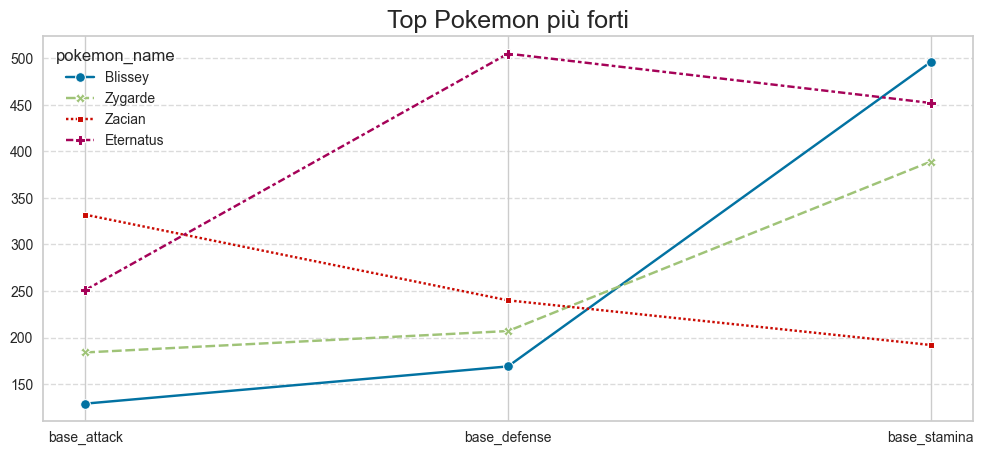

In [7]:
# Strongest Pokemons.
# Create the base_total column
pokemon['base_total'] = pokemon['base_attack'] + pokemon['base_defense'] + pokemon['base_stamina']

# selecting rows based on condition base_total > 750
pokemon_top = pokemon[pokemon['base_total'] > 750]

# columns
pokemon_top = pokemon_top[["pokemon_name", "base_attack", "base_defense", "base_stamina"]]

# changing the index
pokemon_top = pokemon_top.set_index('pokemon_name')

# transposing the dataframe
pokemon_top = pokemon_top.T

pokemon_top
# Visualizing the abilities of the Top  Pokemons

fig, ax = plt.subplots(figsize=(12, 5))
sns.lineplot(data=pokemon_top, markers=True)
plt.title("Top Pokemon più forti", fontsize = 18)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

In [8]:
# Selezioniamo le colonne di interesse
selected_cols = ['base_attack', 'base_defense', 'base_stamina']

for col in selected_cols:
    # Raggruppiamo per 'pokemon_name' e sommiamo i valori della colonna corrente,
    # poi ordiniamo in modo decrescente e selezioniamo le prime 10 righe
    df_sp = (
        pokemon.groupby('pokemon_name')[[col]]
        .sum()
        .sort_values(col, ascending=False)
        .round(2)
        .head(10)
        .reset_index()
    )
    
    # Creiamo il grafico a barre per la colonna corrente
    fig = px.bar(
        df_sp,
        x='pokemon_name',
        y=col,
        title=f"Top 10 Pokémon per {col}",
        template='ggplot2',
        color='pokemon_name',
        text=col
    )
    fig.show()


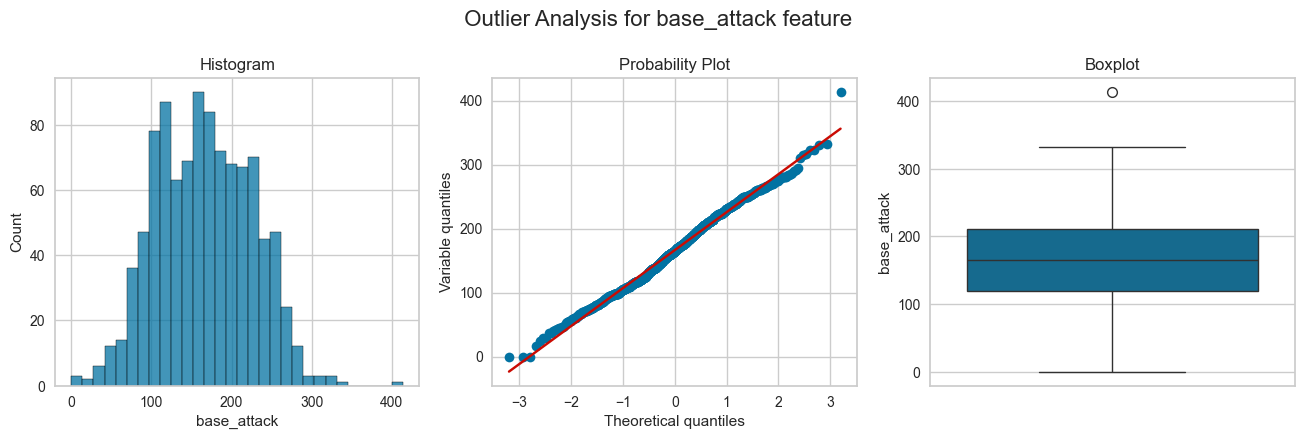

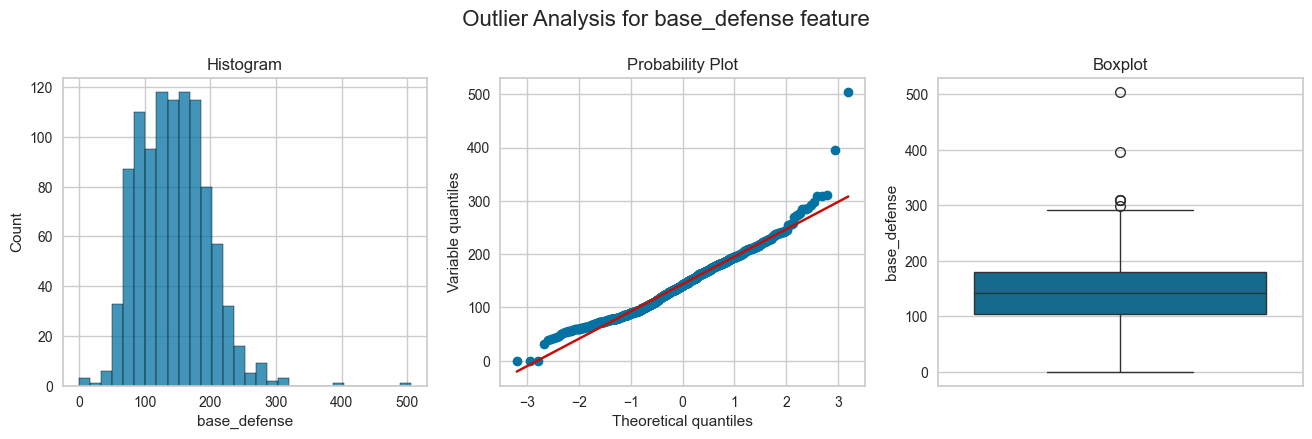

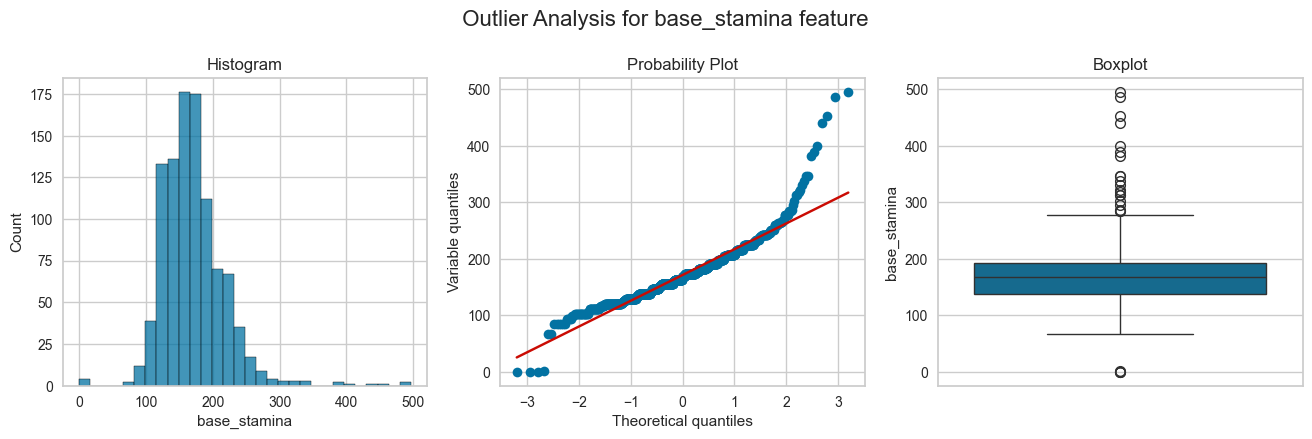

In [9]:
# function to check histogram, distribution plot, and boxplot

def check_plot(pokemon, variable):
    # check distribution plot from variable in df.

    # figure size and title
    plt.figure(figsize=(16, 4))
    plt.suptitle(f' Outlier Analysis for {variable} feature', fontsize=16, y=1.05)

    # histogram
    plt.subplot(1, 3, 1)
    sns.histplot(pokemon[variable], bins = 30)
    plt.title('Histogram')

    # distribution (Q-Q) plot
    plt.subplot(1, 3, 2)
    stats.probplot(pokemon[variable], dist="norm", plot=plt)
    plt.ylabel('Variable quantiles')

    # box plot
    plt.subplot(1, 3, 3)
    sns.boxplot(y=pokemon[variable])
    plt.title('Boxplot')

    plt.show()
    # plot looping for distribution analysis each features

# Seleziona le statistiche di battaglia per il clustering.
# In questo esempio usiamo base_attack, base_defense e base_stamina.
selected_features = ['base_attack', 'base_defense', 'base_stamina']
pokemon_feature = pokemon[selected_features]

for col in selected_features:
    check_plot(pokemon, col)

In [10]:
# Funzione per calcolare le statistiche numeriche senza visualizzare i grafici
def check_statistics(pokemon, variable):
    stats = pokemon[variable].describe()  # Calcola le statistiche descrittive
    print(f"Statistics for {variable}:")
    print(stats)
    print("\n")

# Seleziona le statistiche di battaglia per il clustering.
# In questo esempio usiamo base_attack, base_defense e base_stamina.
selected_features = ['base_attack', 'base_defense', 'base_stamina']
pokemon_feature = pokemon[selected_features]

# Calcolare e stampare le statistiche per ogni variabile selezionata
for col in selected_features:
    check_statistics(pokemon, col)

Statistics for base_attack:
count    1007.000000
mean      166.268123
std        59.382689
min         0.000000
25%       119.000000
50%       165.000000
75%       211.000000
max       414.000000
Name: base_attack, dtype: float64


Statistics for base_defense:
count    1007.000000
mean      143.824230
std        52.023124
min         0.000000
25%       103.000000
50%       142.000000
75%       179.000000
max       505.000000
Name: base_defense, dtype: float64


Statistics for base_stamina:
count    1007.000000
mean      171.078451
std        47.956251
min         0.000000
25%       137.000000
50%       167.000000
75%       193.000000
max       496.000000
Name: base_stamina, dtype: float64




<Axes: >

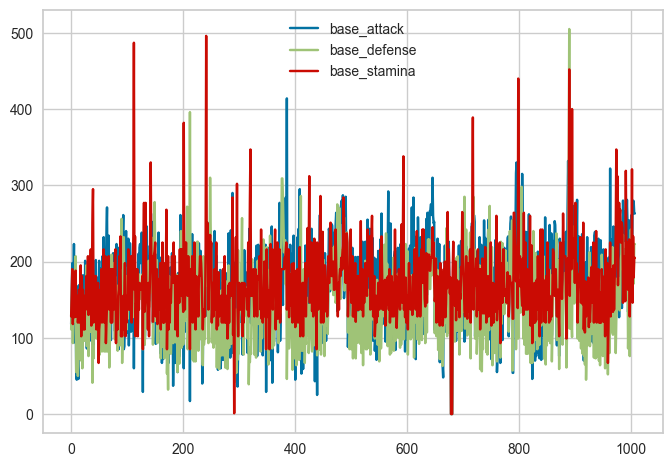

In [11]:
# Plotting all data 
data1 = pokemon.loc[:,["base_attack","base_defense","base_stamina"]]
data1.plot()
# it is confusing

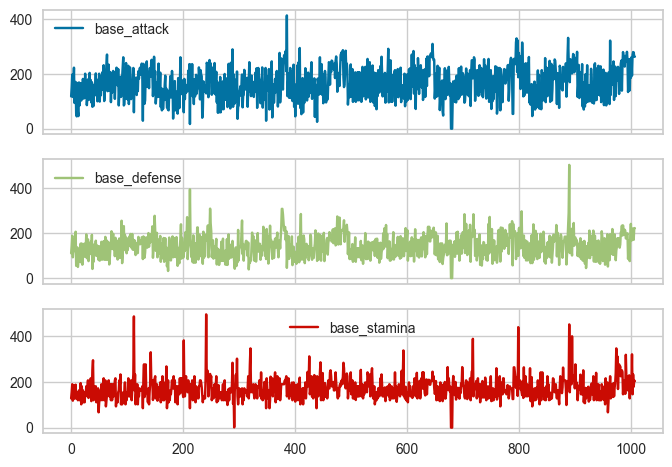

In [12]:
# subplots
data1.plot(subplots = True)
plt.show()

C:\Users\gabri\AppData\Local\Temp\ipykernel_24596\1389791691.py:14: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




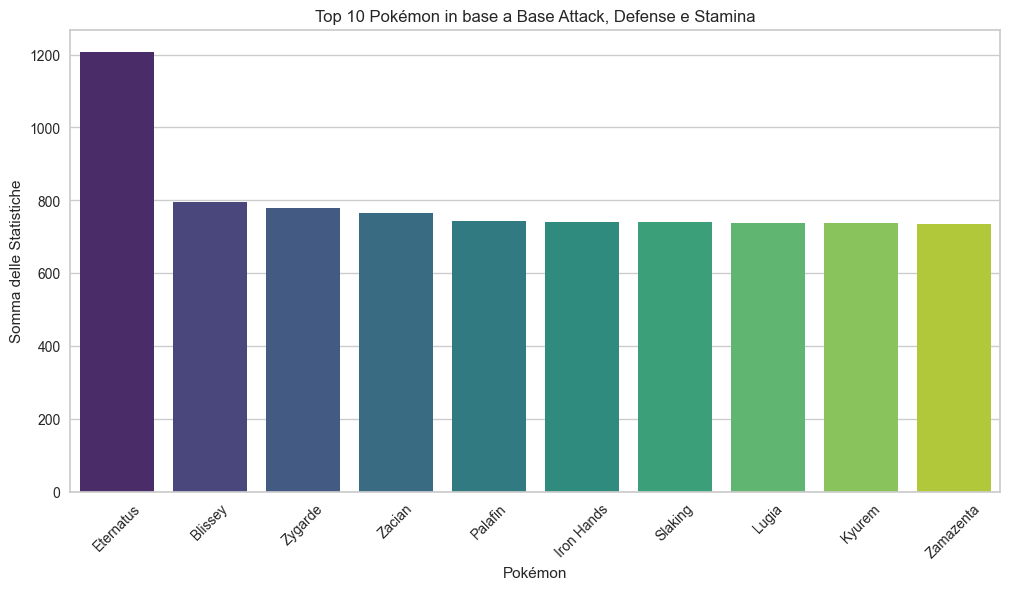

In [13]:
# Simulazione dei nomi dei Pokémon
pokemon_names = [f"Pokemon_{i}" for i in range(200)]
pokemon_name = pokemon["pokemon_name"]

# Definizione delle qualità da analizzare
qualita = ["base_attack", "base_defense", "base_stamina"]

# Calcolo dei top 10 Pokémon basati sulla somma delle qualità selezionate
pokemon["total_stats"] = pokemon[qualita].sum(axis=1)
top_10_pokemon = pokemon.nlargest(10, "total_stats")

# Creazione del grafico
plt.figure(figsize=(12, 6))
ax = sns.barplot(
    data=top_10_pokemon, 
    x="pokemon_name", 
    y="total_stats", 
    palette="viridis"
)

plt.xticks(rotation=45)
plt.xlabel("Pokémon")
plt.ylabel("Somma delle Statistiche")
plt.title("Top 10 Pokémon in base a Base Attack, Defense e Stamina")
plt.show()


C:\Users\gabri\AppData\Local\Temp\ipykernel_24596\682475361.py:26: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




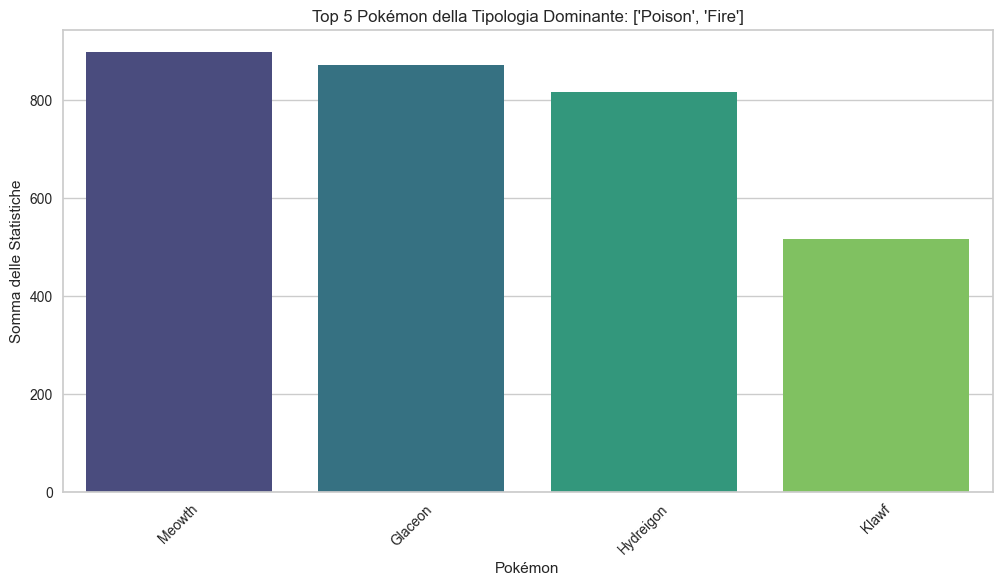

In [14]:
# Simulazione delle tipologie di Pokémon
pokemon_type = pokemon["type"].unique() 
pokemon_name = pokemon["pokemon_name"]
data = {
    "pokemon_name": np.random.choice(pokemon_name, 200),
    "type": np.random.choice(pokemon_type, 200),
    "base_attack": np.random.randint(50, 400, 200),
    "base_defense": np.random.randint(50, 400, 200),
    "base_stamina": np.random.randint(50, 400, 200)
}
df = pd.DataFrame(data)

# Calcolo del punteggio totale
qualita = ["base_attack", "base_defense", "base_stamina"]
df["total_stats"] = df[qualita].sum(axis=1)

# Identificazione della tipologia dominante
type_dominant = df.groupby("type")["total_stats"].sum().idxmax()
df_dominant = df[df["type"] == type_dominant]

# Selezione dei top 10 per la tipologia dominante
top_10_dominant = df_dominant.nlargest(10, "total_stats")

# Creazione del grafico
plt.figure(figsize=(12, 6))
sns.barplot(data=top_10_dominant, x="pokemon_name", y="total_stats", palette="viridis")
plt.xticks(rotation=45)
plt.xlabel("Pokémon")
plt.ylabel("Somma delle Statistiche")
plt.title(f"Top 5 Pokémon della Tipologia Dominante: {type_dominant}")
plt.show()


C:\Users\gabri\AppData\Local\Temp\ipykernel_24596\2555354884.py:15: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




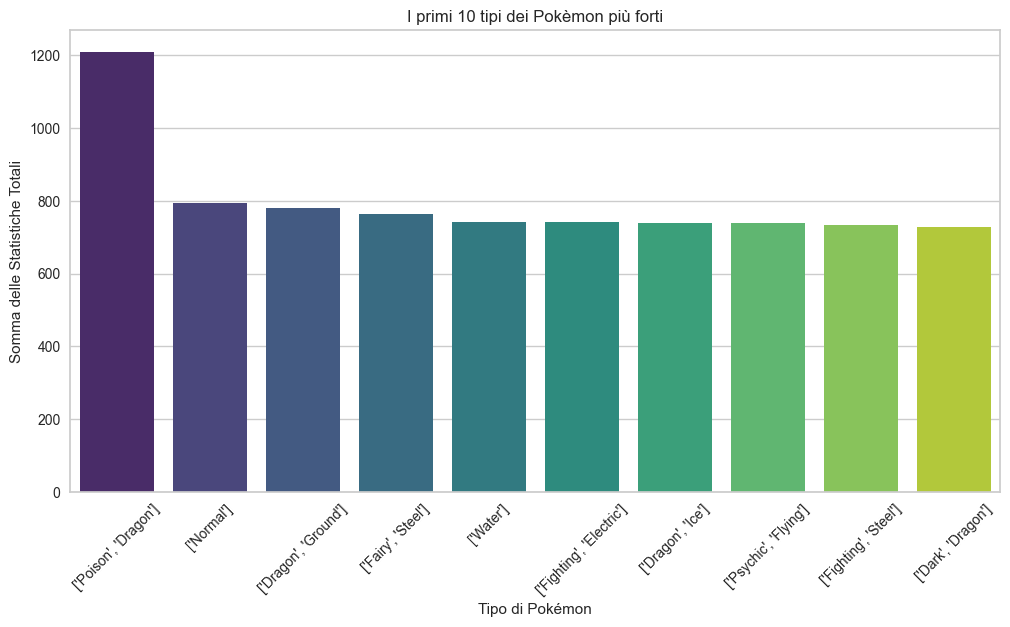

In [15]:
# Calcolo della somma delle statistiche (base_attack + base_defense + base_stamina)
pokemon['TOTAL'] = pokemon['base_attack'] + pokemon['base_defense'] + pokemon['base_stamina']

# Ordinamento dei Pokémon per la somma totale delle statistiche in ordine decrescente
strong = pokemon.sort_values(by='TOTAL', ascending=False)

# Selezione solo il Pokémon più forte per ogni tipo (TYPE)
strongest_per_type = strong.drop_duplicates(subset=['type'], keep='first')

## Selezione dei primi 10 Pokémon più forti
top_10_strongest = strongest_per_type.head(10)

# Creazione del grafico
plt.figure(figsize=(12, 6))
sns.barplot(data=top_10_strongest, x='type', y='TOTAL', palette='viridis')

# Aggiunta di etichette e titolo
plt.xlabel("Tipo di Pokémon")
plt.ylabel("Somma delle Statistiche Totali")
plt.title("I primi 10 tipi dei Pokèmon più forti")
plt.xticks(rotation=45)
plt.show()

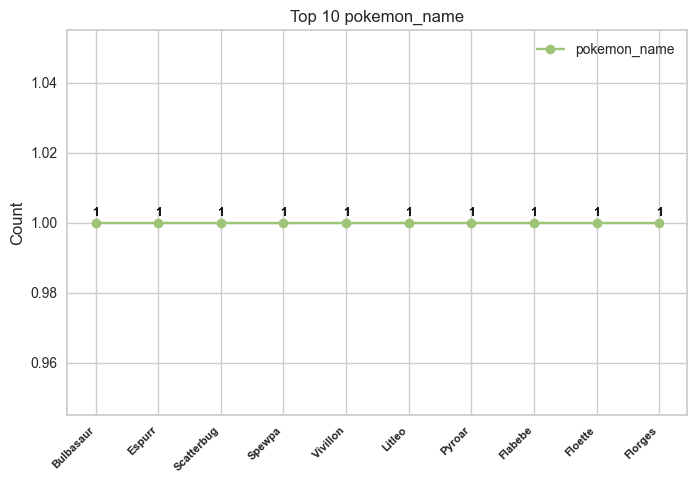

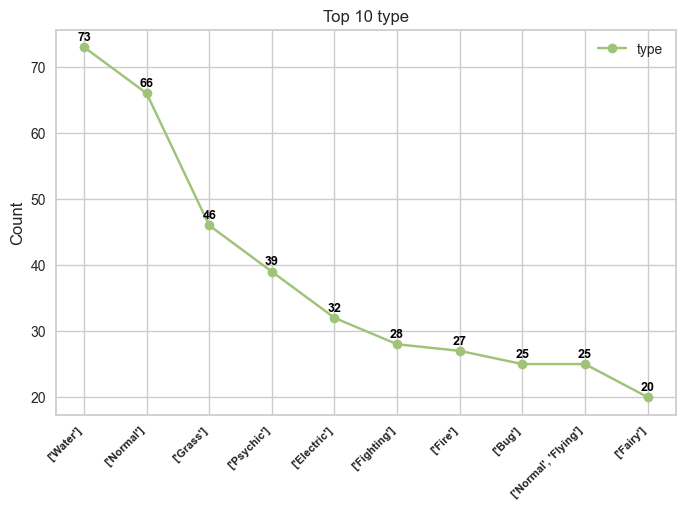

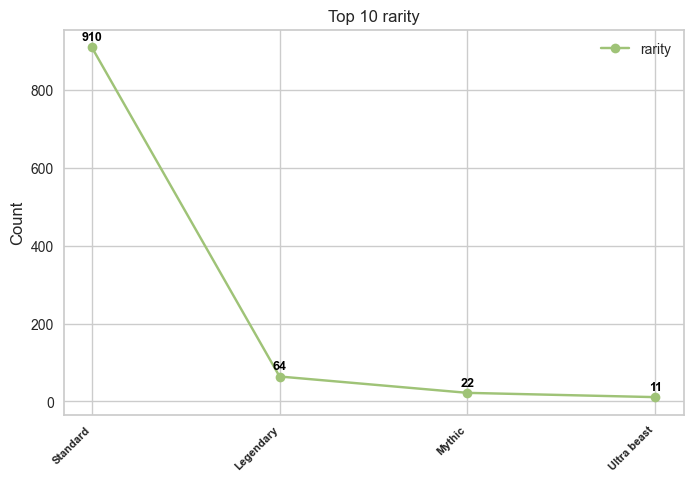

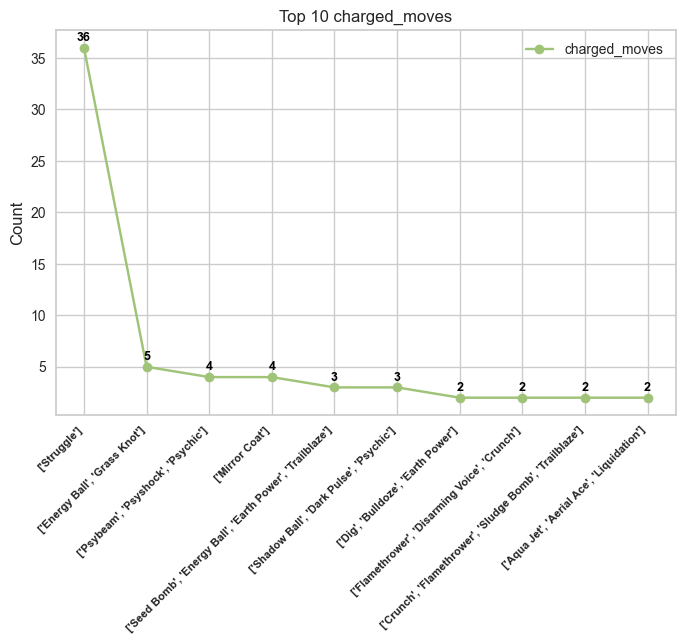

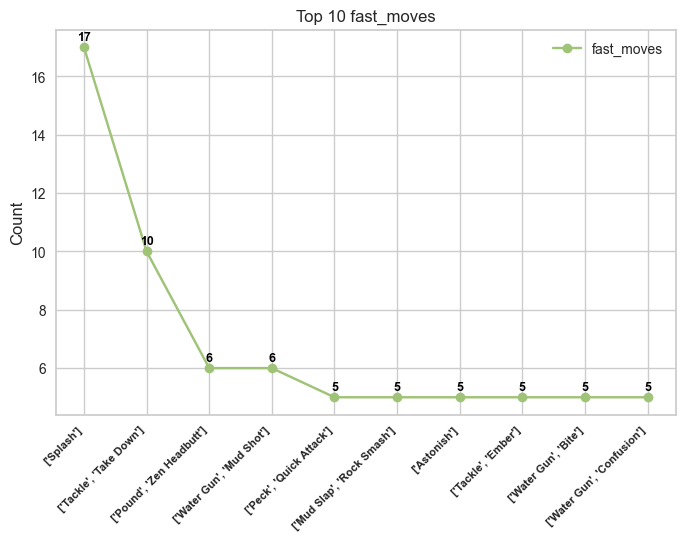

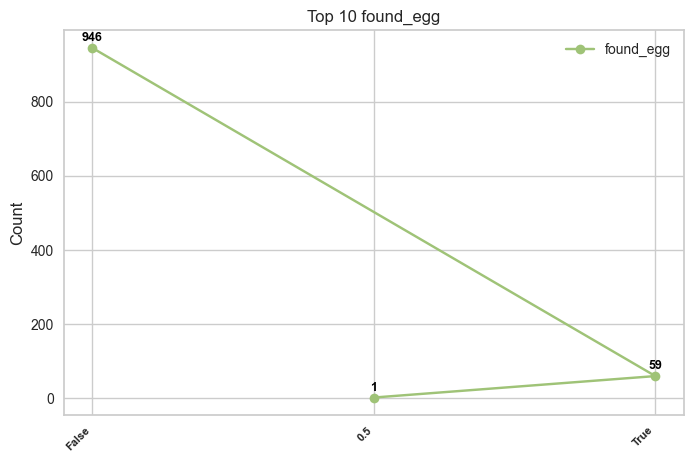

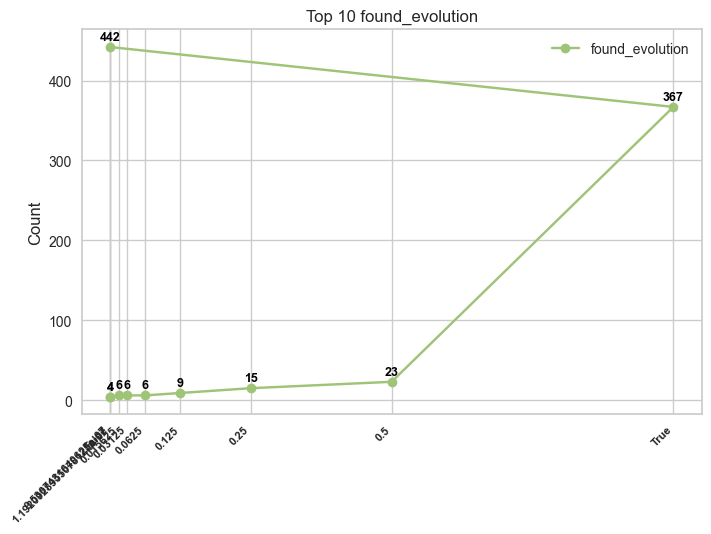

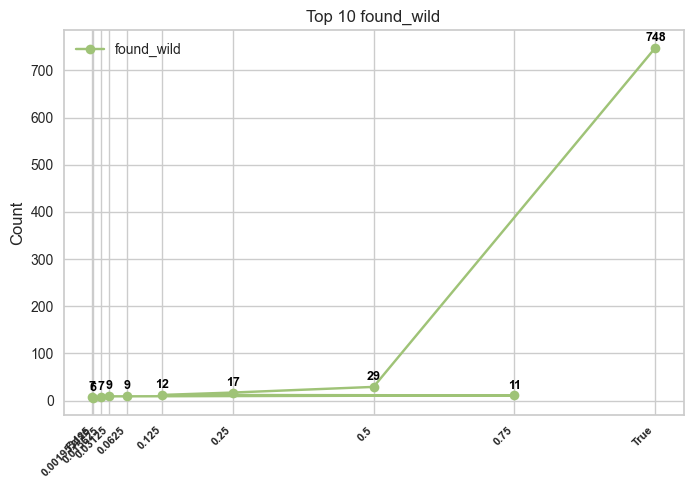

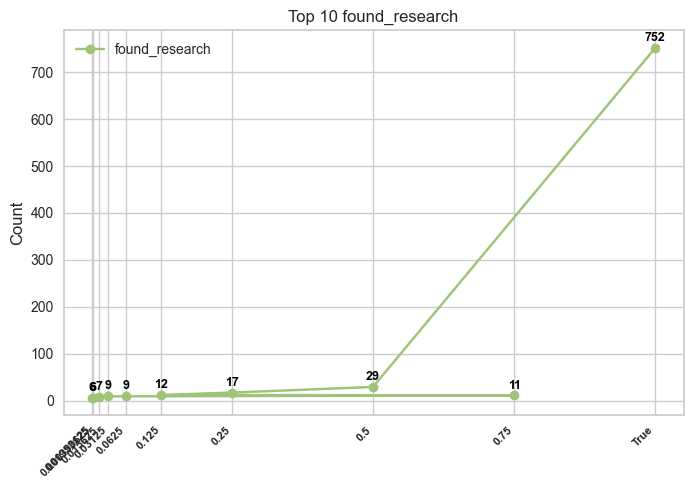

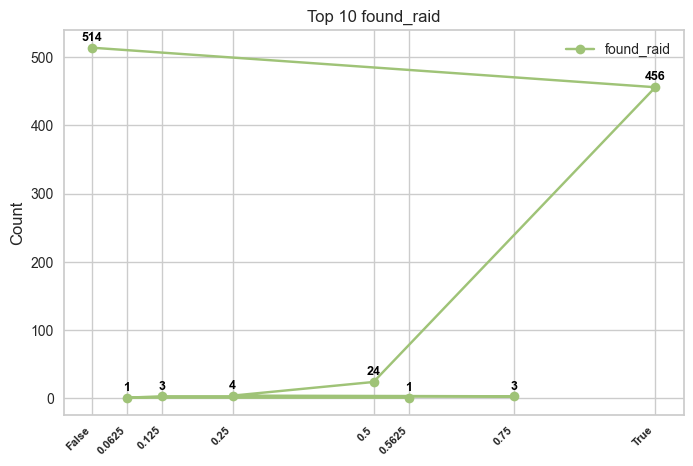

In [16]:
# Categorical variables:
cat_cols = pokemon.select_dtypes(include=['object', 'category']).columns.to_list()

for i, col in enumerate(cat_cols[:10]):  # Consideriamo solo le prime 10 variabili categoriali
    
    # Creiamo la figura
    fig, ax = plt.subplots(figsize=(8, 5))
    
    # Creiamo il dataframe con i primi 10 valori più frequenti
    df_name = pokemon[col].value_counts().head(10)
    
    # Estraiamo etichette e valori
    labels = df_name.index.to_list()
    values = df_name.values
    
    # Generiamo il plot
    ax.plot(labels, values, marker='o', linestyle='-', color='g', label=col)
    
    # Aggiungiamo titolo e etichette
    ax.set_title(f"Top 10 {col}", fontsize=12)
    ax.set_ylabel('Count', fontsize=12)
    ax.set_xticks(labels)
    ax.set_xticklabels(labels, fontsize=8, fontweight='bold', rotation=45, ha='right')
    
    # Aggiungiamo le etichette sui punti
    for j, txt in enumerate(values):
        ax.annotate(txt, (labels[j], values[j]), textcoords="offset points", xytext=(0,5), ha='center', fontsize=9, fontweight='bold', color='black')
    
    # Mostriamo il grafico
    plt.legend()
    plt.grid(True)
    plt.show()


## Modifica del dataset per Classificazione

### Conversione dei tipi di dato in formato numerico

In [17]:
# Verifica e converti i tipi di dati in formato numerico
numeric_columns = ['base_attack', 'base_defense', 'base_stamina', 'max_cp', 
                   'attack_probability', 'dodge_probability', 
                   'max_pokemon_action_frequency', 'min_pokemon_action_frequency', 'base_capture_rate', 'base_flee_rate']

# Converte le colonne in numerico, sostituendo gli errori con NaN
for col in numeric_columns:
    pokemon[col] = pd.to_numeric(pokemon[col], errors='coerce')

# Sostituisci i valori NaN con la media della colonna
for col in numeric_columns:
    pokemon[col].fillna(pokemon[col].mean(), inplace=True)

In [18]:
def count_moves(moves_val):
    """
    Converte una stringa che rappresenta una lista di mosse in una lista e restituisce il numero di mosse.
    Se la conversione fallisce, restituisce 0.
    """
    if pd.isna(moves_val):
        return 0
    moves_val = moves_val.strip()
    if moves_val == "" or moves_val.lower() in ["nan", "none"]:
        return 0
    try:
        moves_list = ast.literal_eval(moves_val)
        if isinstance(moves_list, list):
            return len(moves_list)
        else:
            return 0
    except Exception as e:
        print(f"Errore nel parsing di: {moves_val} -> {e}")
        return 0

### Creazione colonna total_moves

In [19]:
# Applica la funzione per ottenere il conteggio delle mosse
pokemon['fast_moves_count'] = pokemon['fast_moves'].apply(count_moves)
pokemon['charged_moves_count'] = pokemon['charged_moves'].apply(count_moves)

# Verifica i risultati
print(pokemon[['pokemon_name', 'fast_moves', 'fast_moves_count', 'charged_moves', 'charged_moves_count']])

# ------------------------------------------------------------------------------
# Ora, ad esempio, se vuoi usare questi count come feature, puoi rimuovere le colonne originali
# oppure rinominarle.
# Per il nostro esempio, creeremo una nuova feature 'total_moves' (somma di fast e charged moves)
pokemon['total_moves'] = pokemon['fast_moves_count'] + pokemon['charged_moves_count']

      pokemon_name                          fast_moves  fast_moves_count  \
0        Bulbasaur             ['Vine Whip', 'Tackle']                 2   
1          Ivysaur         ['Razor Leaf', 'Vine Whip']                 2   
2         Venusaur         ['Razor Leaf', 'Vine Whip']                 2   
3       Charmander                ['Ember', 'Scratch']                 2   
4       Charmeleon              ['Ember', 'Fire Fang']                 2   
...            ...                                 ...               ...   
1002        Chi-Yu             ['Incinerate', 'Snarl']                 2   
1003  Roaring Moon                          ['Splash']                 1   
1004  Iron Valiant                          ['Splash']                 1   
1005      Koraidon       ['Rock Smash', 'Dragon Tail']                 2   
1006      Miraidon  ['Thunder Shock', 'Dragon Breath']                 2   

                                          charged_moves  charged_moves_count  
0       

### Mappatura del punteggio del tipo

In [20]:
# ------------------------------------------------------------------------------
# Mappatura del punteggio del tipo (assumendo che la colonna 'type' sia una stringa)
# Se la colonna 'type' nel CSV contiene, ad esempio, "['Grass', 'Poison']",
# potresti decidere di prendere il primo tipo come riferimento
# Modifica della funzione get_primary_type per supportare più tipi
def get_types(type_str):
    try:
        # Converte la stringa in lista
        types_list = ast.literal_eval(type_str)
        if isinstance(types_list, list) and len(types_list) > 0:
            return types_list  # Restituisce la lista completa dei tipi
        else:
            return [type_str]  # Se è solo un tipo, lo mette in lista
    except Exception as e:
        return [type_str]  # Se c'è un errore, restituisce il tipo originale in lista

# Applica la funzione per estrarre tutti i tipi
pokemon['types'] = pokemon['type'].apply(get_types)

# Se la colonna 'type' è numerica ma i tuoi punteggi sono associati a stringhe, convertila in stringa
# pokemon['type'] = pokemon['type'].astype(str)

In [21]:
# Efficacia dei vari tipi
type_effectiveness = {
    'Bug': {'Bug': 1, 'Dark': 2, 'Dragon': 0.5, 'Electric': 1, 'Fairy': 1, 'Fighting': 2, 'Fire': 0.5, 'Flying': 1, 'Ghost': 1, 
            'Grass': 2, 'Ground': 1, 'Ice': 1, 'Normal': 1, 'Poison': 1, 'Psychic': 1, 'Rock': 2, 'Steel': 1, 'Water': 1},
    'Dark': {'Bug': 1, 'Dark': 1, 'Dragon': 1, 'Electric': 1, 'Fairy': 0.5, 'Fighting': 0.5, 'Fire': 1, 'Flying': 1, 'Ghost': 2, 
             'Grass': 1, 'Ground': 1, 'Ice': 1, 'Normal': 1, 'Poison': 1, 'Psychic': 2, 'Rock': 1, 'Steel': 1, 'Water': 1},
    'Dragon': {'Bug': 1, 'Dark': 1, 'Dragon': 2, 'Electric': 1, 'Fairy': 0.5, 'Fighting': 1, 'Fire': 1, 'Flying': 1, 'Ghost': 1, 
               'Grass': 1, 'Ground': 1, 'Ice': 2, 'Normal': 1, 'Poison': 1, 'Psychic': 1, 'Rock': 1, 'Steel': 1, 'Water': 1},
    'Electric': {'Bug': 1, 'Dark': 1, 'Dragon': 1, 'Electric': 1, 'Fairy': 1, 'Fighting': 1, 'Fire': 1, 'Flying': 2, 'Ghost': 1, 
                 'Grass': 0.5, 'Ground': 0, 'Ice': 1, 'Normal': 1, 'Poison': 1, 'Psychic': 1, 'Rock': 1, 'Steel': 2, 'Water': 2},
    'Fairy': {'Bug': 1, 'Dark': 2, 'Dragon': 2, 'Electric': 1, 'Fairy': 1, 'Fighting': 2, 'Fire': 0.5, 'Flying': 1, 'Ghost': 1, 
              'Grass': 1, 'Ground': 1, 'Ice': 1, 'Normal': 1, 'Poison': 2, 'Psychic': 1, 'Rock': 1, 'Steel': 0.5, 'Water': 1},
    'Fighting': {'Bug': 1, 'Dark': 2, 'Dragon': 1, 'Electric': 1, 'Fairy': 0.5, 'Fighting': 1, 'Fire': 1, 'Flying': 0.5, 'Ghost': 0, 
                 'Grass': 1, 'Ground': 1, 'Ice': 1, 'Normal': 2, 'Poison': 1, 'Psychic': 1, 'Rock': 2, 'Steel': 2, 'Water': 1},
    'Fire': {'Bug': 2, 'Dark': 1, 'Dragon': 1, 'Electric': 1, 'Fairy': 1, 'Fighting': 1, 'Fire': 1, 'Flying': 1, 'Ghost': 1, 
             'Grass': 2, 'Ground': 1, 'Ice': 2, 'Normal': 1, 'Poison': 1, 'Psychic': 1, 'Rock': 2, 'Steel': 2, 'Water': 0.5},
    'Flying': {'Bug': 2, 'Dark': 1, 'Dragon': 1, 'Electric': 0.5, 'Fairy': 1, 'Fighting': 2, 'Fire': 1, 'Flying': 1, 'Ghost': 1, 
               'Grass': 1, 'Ground': 0, 'Ice': 1, 'Normal': 1, 'Poison': 1, 'Psychic': 1, 'Rock': 1, 'Steel': 1, 'Water': 1},
    'Ghost': {'Bug': 1, 'Dark': 1, 'Dragon': 1, 'Electric': 1, 'Fairy': 1, 'Fighting': 0, 'Fire': 1, 'Flying': 1, 'Ghost': 2, 
              'Grass': 1, 'Ground': 1, 'Ice': 1, 'Normal': 0, 'Poison': 1, 'Psychic': 2, 'Rock': 1, 'Steel': 1, 'Water': 1},
    'Grass': {'Bug': 2, 'Dark': 1, 'Dragon': 1, 'Electric': 1, 'Fairy': 1, 'Fighting': 1, 'Fire': 0.5, 'Flying': 1, 'Ghost': 1, 
              'Grass': 1, 'Ground': 2, 'Ice': 1, 'Normal': 1, 'Poison': 0.5, 'Psychic': 1, 'Rock': 2, 'Steel': 1, 'Water': 2},
    'Ground': {'Bug': 1, 'Dark': 1, 'Dragon': 1, 'Electric': 2, 'Fairy': 1, 'Fighting': 1, 'Fire': 1, 'Flying': 0, 'Ghost': 1, 
               'Grass': 1, 'Ground': 1, 'Ice': 1, 'Normal': 1, 'Poison': 2, 'Psychic': 1, 'Rock': 2, 'Steel': 2, 'Water': 1},
    'Ice': {'Bug': 1, 'Dark': 1, 'Dragon': 1, 'Electric': 1, 'Fairy': 1, 'Fighting': 1, 'Fire': 0.5, 'Flying': 1, 'Ghost': 1, 
            'Grass': 2, 'Ground': 2, 'Ice': 1, 'Normal': 1, 'Poison': 1, 'Psychic': 1, 'Rock': 1, 'Steel': 1, 'Water': 2},
    'Normal': {'Bug': 1, 'Dark': 1, 'Dragon': 1, 'Electric': 1, 'Fairy': 1, 'Fighting': 2, 'Fire': 1, 'Flying': 1, 'Ghost': 0, 
               'Grass': 1, 'Ground': 1, 'Ice': 1, 'Normal': 1, 'Poison': 1, 'Psychic': 1, 'Rock': 1, 'Steel': 1, 'Water': 1},
    'Poison': {'Bug': 1, 'Dark': 1, 'Dragon': 1, 'Electric': 1, 'Fairy': 2, 'Fighting': 1, 'Fire': 1, 'Flying': 1, 'Ghost': 1, 
               'Grass': 2, 'Ground': 1, 'Ice': 1, 'Normal': 1, 'Poison': 1, 'Psychic': 1, 'Rock': 1, 'Steel': 0.5, 'Water': 1},
    'Psychic': {'Bug': 1, 'Dark': 1, 'Dragon': 1, 'Electric': 1, 'Fairy': 1, 'Fighting': 1, 'Fire': 1, 'Flying': 1, 'Ghost': 1, 
                'Grass': 1, 'Ground': 1, 'Ice': 1, 'Normal': 1, 'Poison': 1, 'Psychic': 1, 'Rock': 1, 'Steel': 0.5, 'Water': 1},
    'Rock': {'Bug': 2, 'Dark': 1, 'Dragon': 1, 'Electric': 1, 'Fairy': 1, 'Fighting': 1, 'Fire': 2, 'Flying': 2, 'Ghost': 1, 
             'Grass': 1, 'Ground': 1, 'Ice': 1, 'Normal': 1, 'Poison': 1, 'Psychic': 1, 'Rock': 1, 'Steel': 1, 'Water': 1},
    'Steel': {'Bug': 2, 'Dark': 1, 'Dragon': 1, 'Electric': 1, 'Fairy': 2, 'Fighting': 0.5, 'Fire': 0.5, 'Flying': 1, 'Ghost': 1, 
              'Grass': 1, 'Ground': 1, 'Ice': 2, 'Normal': 1, 'Poison': 1, 'Psychic': 1, 'Rock': 2, 'Steel': 1, 'Water': 1},
    'Water': {'Bug': 1, 'Dark': 1, 'Dragon': 1, 'Electric': 1, 'Fairy': 1, 'Fighting': 1, 'Fire': 2, 'Flying': 1, 'Ghost': 1, 
              'Grass': 0.5, 'Ground': 1, 'Ice': 1, 'Normal': 1, 'Poison': 1, 'Psychic': 1, 'Rock': 2, 'Steel': 1, 'Water': 1}
}

In [22]:
# Modifica della funzione get_type_effectiveness per supportare più tipi
def get_type_effectiveness(pokemon_types, against_type):
    effectiveness = 1
    for poke_type in pokemon_types:  # Ora itera su tutti i tipi del Pokémon
        effectiveness *= type_effectiveness.get(poke_type, {}).get(against_type, 1)
    return effectiveness

# Applica la funzione sulla colonna 'type' per creare la nuova colonna 'type_importance'
# pokemon['type_effectiveness'] = pokemon['type'].apply(get_type_importance)

### Analisi sulla classificazione

In [23]:
# ------------------------------------------------------------------------------
# Funzione di classificazione PvP/PvE
def classify_pokemon(row):
    # Calcola l'efficacia totale del tipo contro gli altri tipi (considerando entrambi i tipi)
    total_effectiveness = sum([get_type_effectiveness(row['types'], other_type) for other_type in type_effectiveness.keys()])

    # Stesse regole per PvP/PvE come nel codice originale, ma con i nuovi calcoli
    if row['fast_moves_count'] >= 2:
        if row['max_cp'] <= 1500 and row['base_attack'] >= 140 and row['base_defense'] >= 86 and row['base_stamina'] >= 104 and row['dodge_probability'] >= 0.15:
            return 1  # PvP
        elif row['max_cp'] <= 2500 and row['base_attack'] >= 180 and row['base_defense'] >= 112 and row['base_stamina'] >= 136 and row['dodge_probability'] >= 0.15:
            return 1  # PvP
        elif row['max_cp'] > 2500 and row['base_attack'] >= 194 and row['base_defense'] >= 118 and row['base_stamina'] >= 144 and row['dodge_probability'] >= 0.15:
            return 1  # PvP
        elif total_effectiveness >= 25:  # Se l'efficacia del tipo è molto alta contro gli altri tipi
            return 1  # PvP
        else:
            return 0  # PvE
    else:
        return 0  # PvE

pokemon['class'] = pokemon.apply(classify_pokemon, axis=1)

In [24]:
# Classificazione PvP/PvE
print("\nClassificazione PvE (0) vs PvP (1):\n", pokemon[['pokemon_name', 'class']])


Classificazione PvE (0) vs PvP (1):
       pokemon_name  class
0        Bulbasaur      0
1          Ivysaur      0
2         Venusaur      1
3       Charmander      0
4       Charmeleon      0
...            ...    ...
1002        Chi-Yu      0
1003  Roaring Moon      0
1004  Iron Valiant      0
1005      Koraidon      0
1006      Miraidon      0

[1007 rows x 2 columns]


In [25]:
# Visualizza la distribuzione delle classi
print("\nDistribuzione classi PvE (0) vs PvP (1):\n", pokemon['class'].value_counts(normalize=True))


Distribuzione classi PvE (0) vs PvP (1):
 class
0    0.696127
1    0.303873
Name: proportion, dtype: float64


In [26]:
# Calcola la correlazione tra le feature numeriche
def calculate_type_effectiveness(row):
    total_effectiveness = sum([get_type_effectiveness(row['types'], other_type) for other_type in type_effectiveness.keys()])
    return total_effectiveness

In [27]:
# Definizione delle feature: usiamo solo quelle presenti nel dataset
features = [
    'base_attack', 'base_defense', 'base_stamina', 'candy_required',
    'distance', 'max_cp', 'attack_probability', 'base_capture_rate',
    'base_flee_rate', 'dodge_probability', 'max_pokemon_action_frequency',
    'min_pokemon_action_frequency', 'fast_moves_count', 'charged_moves_count',
    'total_moves', 'type_effectiveness_score'
]

# Calcola l'efficacia totale per ogni Pokémon
pokemon['type_effectiveness_score'] = pokemon.apply(calculate_type_effectiveness, axis=1)

print("\nEfficacia totale per ogni Pokémon:\n", pokemon[['pokemon_name', 'type_effectiveness_score']])


Efficacia totale per ogni Pokémon:
       pokemon_name  type_effectiveness_score
0        Bulbasaur                     22.50
1          Ivysaur                     22.50
2         Venusaur                     22.50
3       Charmander                     22.50
4       Charmeleon                     22.50
...            ...                       ...
1002        Chi-Yu                     23.50
1003  Roaring Moon                     20.75
1004  Iron Valiant                     23.50
1005      Koraidon                     21.75
1006      Miraidon                     21.00

[1007 rows x 2 columns]



Accuracy: 0.9851485148514851

Confusion Matrix:
 [[141   0]
 [  3  58]]

Classification Report:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99       141
           1       1.00      0.95      0.97        61

    accuracy                           0.99       202
   macro avg       0.99      0.98      0.98       202
weighted avg       0.99      0.99      0.99       202



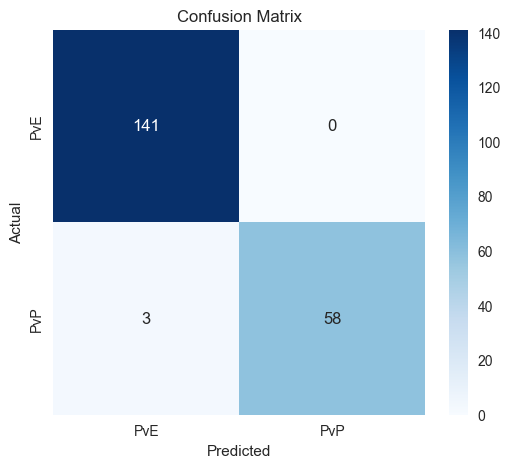

In [28]:
# Preparazione dei dati
X = pokemon[features]
y = pokemon['class']

# Suddivisione del dataset in training e test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Addestramento del modello
clf = RandomForestClassifier(n_estimators=200, random_state=42)
clf.fit(X_train, y_train)

# Predizione e valutazione delle performance
y_pred = clf.predict(X_test)
print("\nAccuracy:", accuracy_score(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Stampa della matrice di confusione
plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues', xticklabels=["PvE", "PvP"], yticklabels=["PvE", "PvP"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

### Analisi feature importanti

In [43]:
# Analisi delle feature più importanti
importances = pd.DataFrame({'feature': X.columns, 'importance': clf.feature_importances_})
print("\nFeature Importances:\n", importances.sort_values(by='importance', ascending=False))


Feature Importances:
                          feature  importance
0                    base_attack    0.331750
5                         max_cp    0.176875
15      type_effectiveness_score    0.114000
1                   base_defense    0.088842
9              dodge_probability    0.078276
2                   base_stamina    0.057577
14                   total_moves    0.021471
12              fast_moves_count    0.017966
8                 base_flee_rate    0.016397
10  max_pokemon_action_frequency    0.016104
6             attack_probability    0.016015
7              base_capture_rate    0.015000
13           charged_moves_count    0.014586
3                 candy_required    0.013353
11  min_pokemon_action_frequency    0.013349
4                       distance    0.008440


In [44]:
# Analisi delle predizioni
print("\nDistribuzione delle predizioni:\n", pd.Series(y_pred).value_counts(normalize=True))


Distribuzione delle predizioni:
 0    0.712871
1    0.287129
Name: proportion, dtype: float64


## Clustering

### Analisi dataset per Clustering

In [ ]:
# feature standardization to ensure each features have similar scales
# Definite precedentemente ma mostrate per una migliore comprensione:
# selected_features = ['base_attack', 'base_defense', 'base_stamina']
print(pokemon[selected_features].isna().sum())
pokemon = pokemon.dropna(subset=selected_features)
print(pokemon[selected_features].isna().sum())

scaler = StandardScaler()
scaled_features = scaler.fit_transform(pokemon[selected_features])

base_attack     0
base_defense    0
base_stamina    0
dtype: int64
base_attack     0
base_defense    0
base_stamina    0
dtype: int64


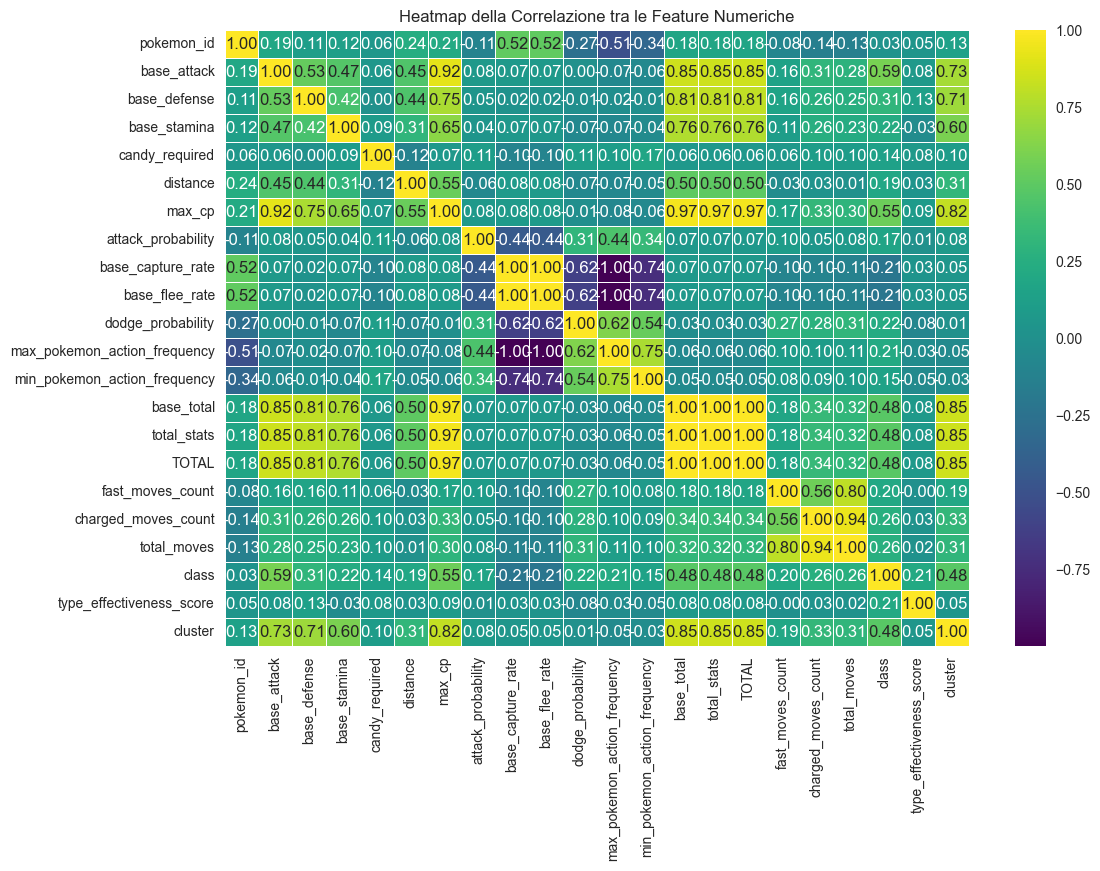

In [ ]:
# Selezione solo le colonne numeriche
df_numeric = pokemon.select_dtypes(include=[np.number])

# Calcolo della matrice di correlazione
corr_matrix = df_numeric.corr()

# Creazione della heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="viridis", linewidths=0.5)
plt.title("Heatmap della Correlazione tra le Feature Numeriche")
plt.show()

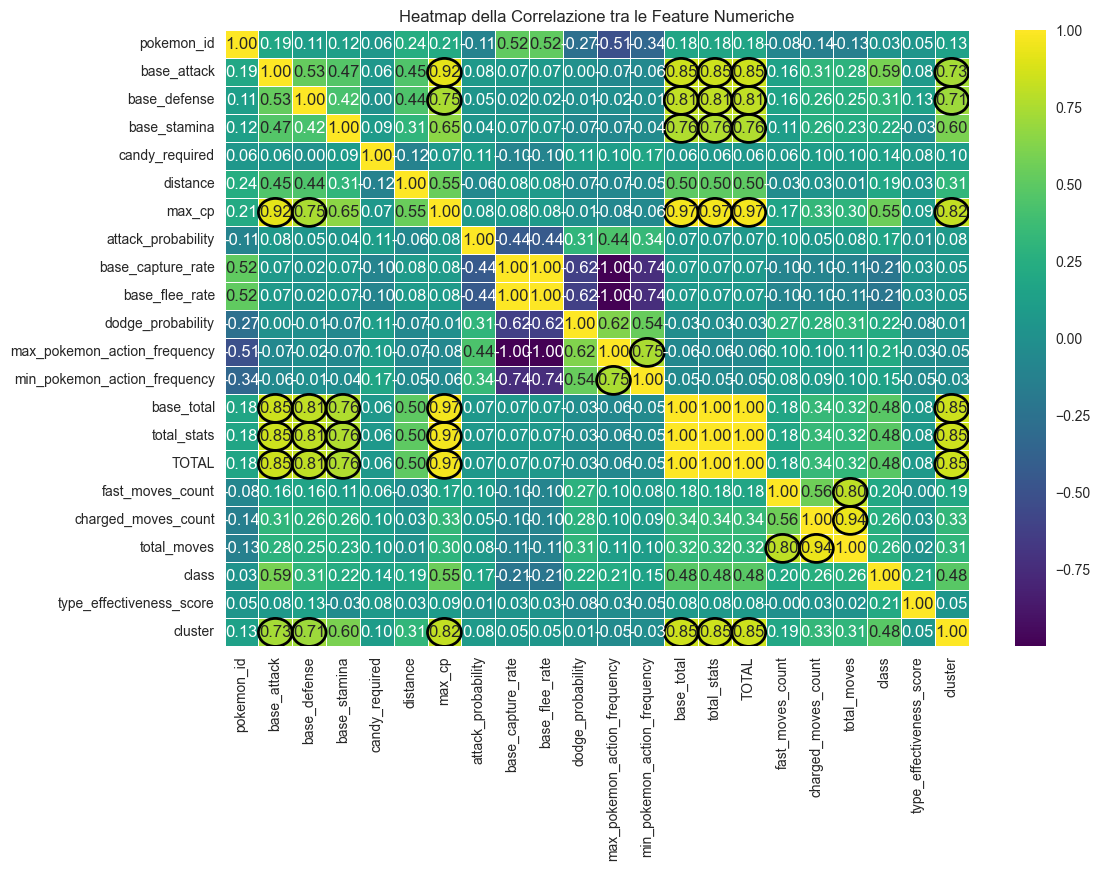

In [ ]:
# Creazione della heatmap con cerchi sui valori di correlazione > 0.7 e < 1
# Per una migliore visualizzazione e comprensione
plt.figure(figsize=(12, 8))
ax = sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="viridis", linewidths=0.5)

# Evidenziazione dei valori sopra 0.7 e sotto 1 con un cerchio
for i in range(len(corr_matrix.columns)):
    for j in range(len(corr_matrix.columns)):
        value = corr_matrix.iloc[i, j]
        if 0.7 < value < 1:  # Controllo sulla soglia
            ax.add_patch(plt.Circle((j + 0.5, i + 0.5), 0.5, color='black', fill=False, linewidth=2))

plt.title("Heatmap della Correlazione tra le Feature Numeriche")
plt.show()

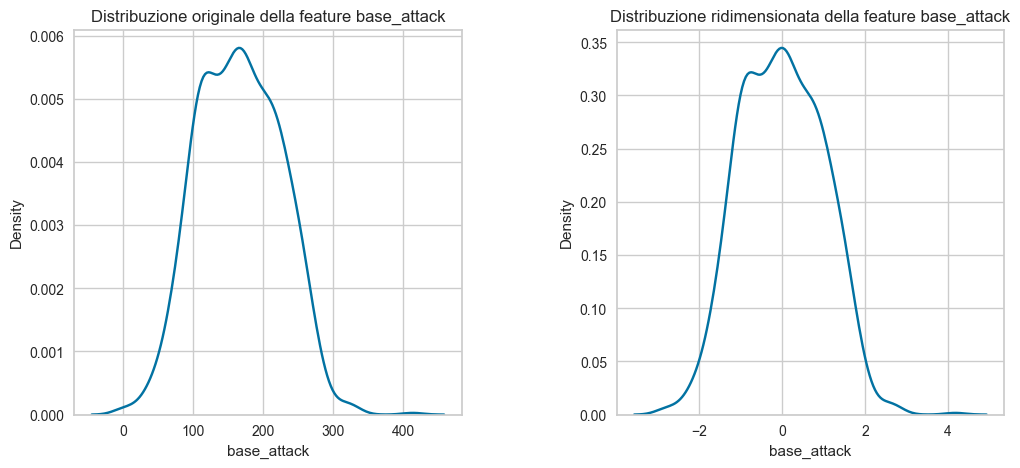

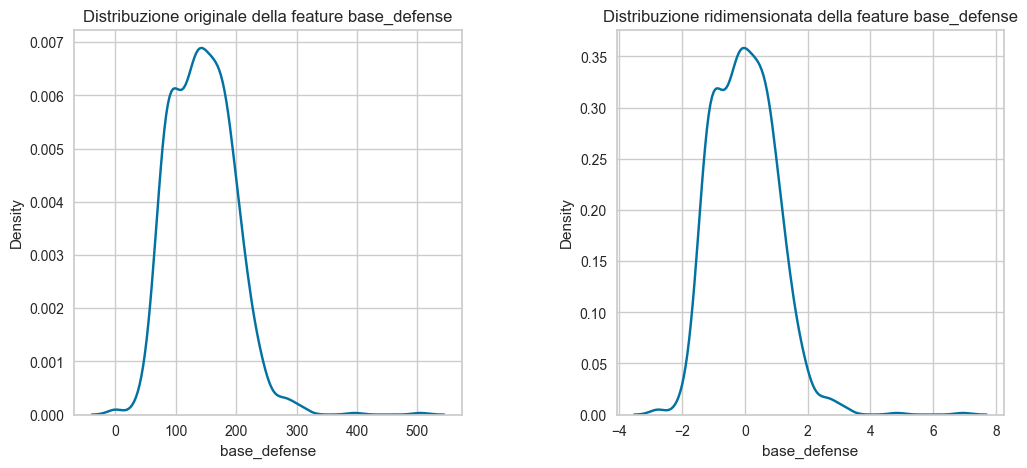

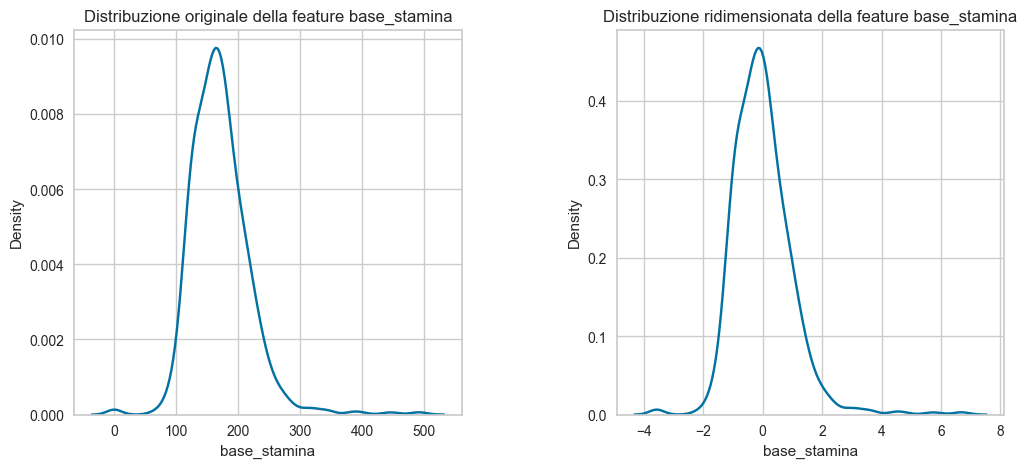

In [ ]:
# confrontando ciascuna funzionalità prima e dopo il ridimensionamento delle funzionalità
scaled_features = pd.DataFrame(scaled_features,columns= selected_features)

for col in selected_features:
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # 1 riga, 2 colonne, con dimensioni personalizzate
    fig.subplots_adjust(wspace=0.4)  # Aggiunge spazio orizzontale tra i grafici

    sns.kdeplot(pokemon[col], ax=axes[0])
    axes[0].set_title(f'Distribuzione originale della feature {col}')

    sns.kdeplot(scaled_features[col], ax=axes[1])
    axes[1].set_title(f'Distribuzione ridimensionata della feature {col}')

    plt.show()

### Metodo del gomito per determinare il numero ottimale di cluster

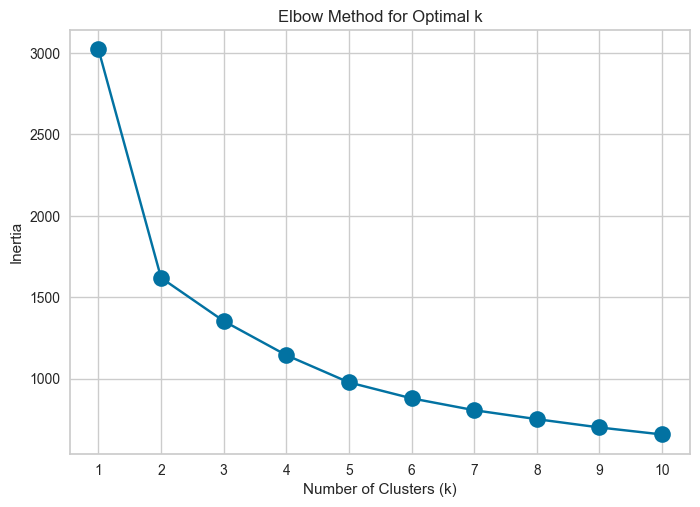

In [49]:
# Metodo del gomito per determinare il numero ottimale di cluster
inertia = []
for n_clusters in range(1, 11):
    kmeans = KMeans(n_clusters=n_clusters, init='k-means++', max_iter=300, n_init=10, random_state=42)
    kmeans.fit(scaled_features)
    inertia.append(kmeans.inertia_)

# Plotting the Elbow Curve

plt.plot(range(1, 11), inertia, marker='o', markersize= 12, linestyle='-', color='b')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.xticks(range(1, 11))
plt.grid(True)
plt.show()


### Nota
*Sulla base dell'analisi del gomito illustrata nel grafico e nella tabella, dopo k = 4, non vi è alcuna diminuzione significativa dell'inerzia (meno del 10% della diminuzione dell'inerzia dopo il numero del cluster = 4). Pertanto, il numero ottimale di cluster dall'analisi del gomito è 4*

### Applicazione k-means con *k=4*

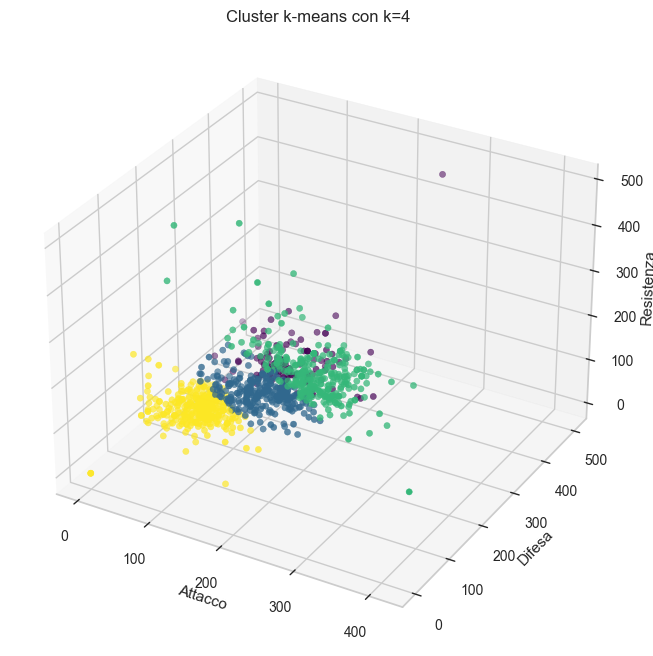

In [ ]:
# Supposto che il miglior k sia 4 (suggerito dal metodo del gomito)
optimal_k = 4  # Modifica con il k trovato dal metodo del gomito

# Applicazione di k-means con k=4
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
pokemon["cluster"] = kmeans.fit_predict(scaled_features)

# Visualizzazione dei risultati in un grafico 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection="3d")

# Scatter plot dei dati colorati per cluster
ax.scatter(pokemon["base_attack"], pokemon["base_defense"], pokemon["base_stamina"], c=pokemon["cluster"], cmap="viridis")

ax.set_xlabel("Attacco")
ax.set_ylabel("Difesa")
ax.set_zlabel("Resistenza")
ax.set_title(f"Cluster k-means con k={optimal_k}")

plt.show()

### Metodo della silhouette per determinare il numero ottimale di cluster

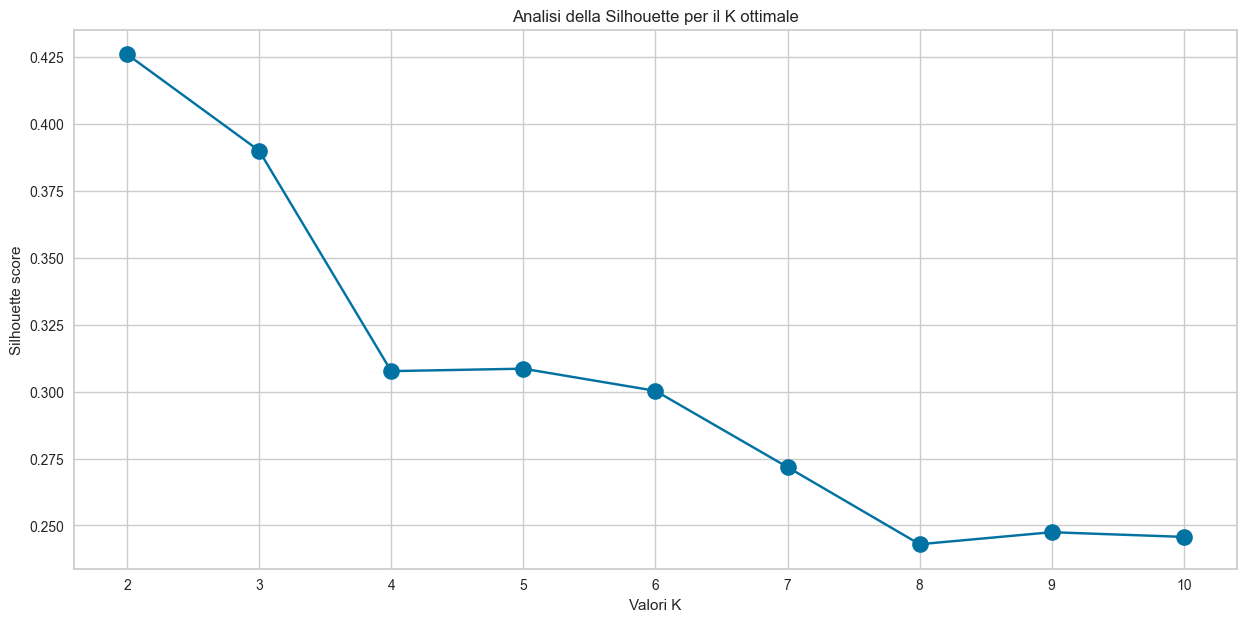

Numeri ottimi per il cluster: 2 con la media della silhouette score 0.426


In [51]:
# Range del numero di cluster 
min_clusters = 2
max_clusters = 10

# Calcula lo score della silhouette da diversi numeri di cluster

silhouette_scores = []

for n_clusters in range(min_clusters, max_clusters+1):
    kmeans = KMeans(n_clusters=n_clusters,  init='k-means++', max_iter=300, n_init=10, random_state = 42)
    cluster_labels = kmeans.fit_predict(scaled_features)
    silhouette_avg = silhouette_score(scaled_features, cluster_labels)
    silhouette_scores.append(silhouette_avg)

# Trova il numero ottimale di cluster con lo score della silhouette più alto
optimal_num_clusters = np.argmax(silhouette_scores) + min_clusters

range_n_clusters = range(2,11)
plt.figure(figsize=(15, 7))
plt.plot(range_n_clusters, silhouette_scores, marker='o', markersize= 12, linestyle='-', color='b')
plt.xlabel('Valori K')
plt.ylabel('Silhouette score')
plt.title('Analisi della Silhouette per il K ottimale')
plt.show()

print(f"Numeri ottimi per il cluster: {optimal_num_clusters} con la media della silhouette score {round(max(silhouette_scores),3)}")


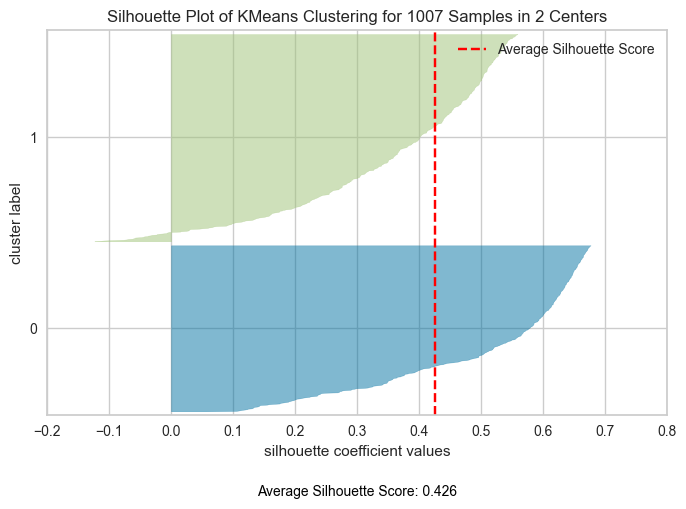

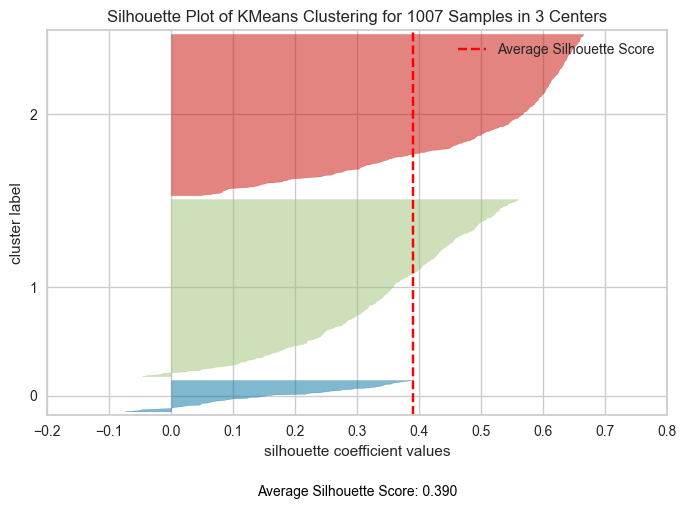

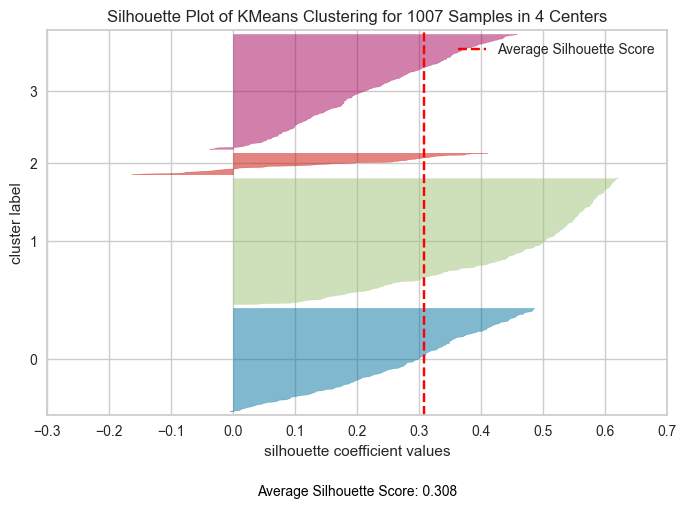

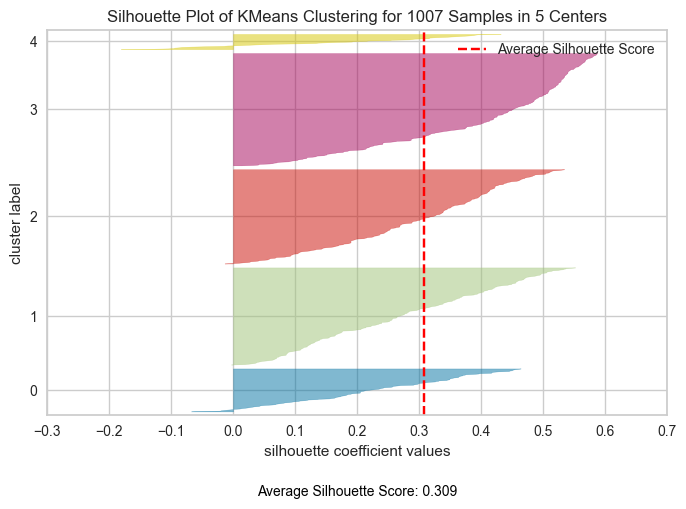

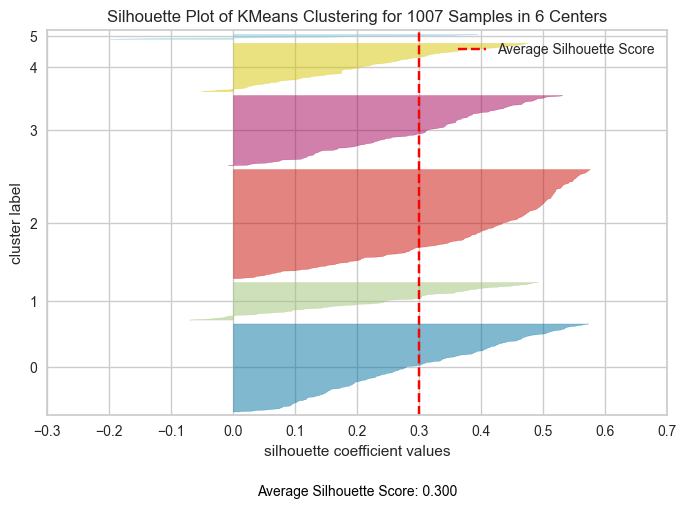

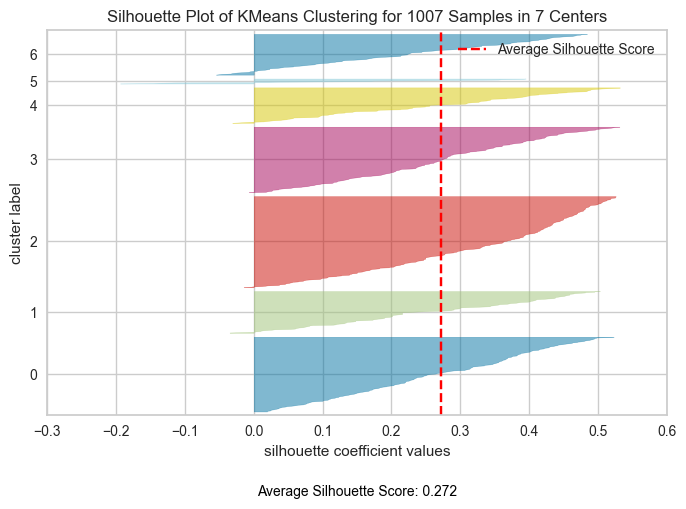

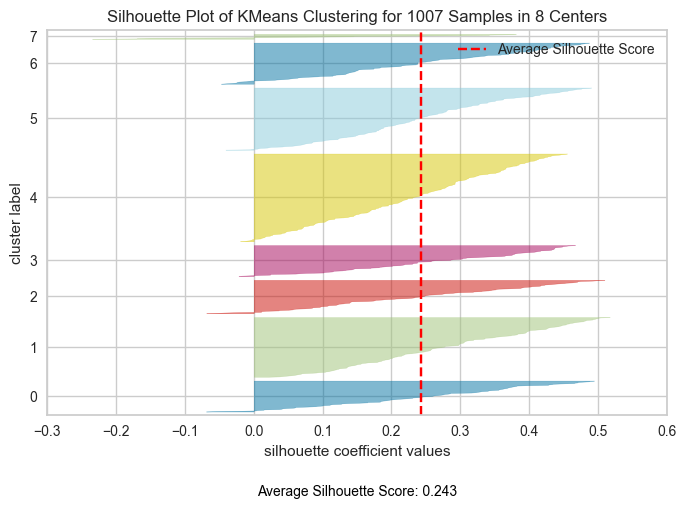

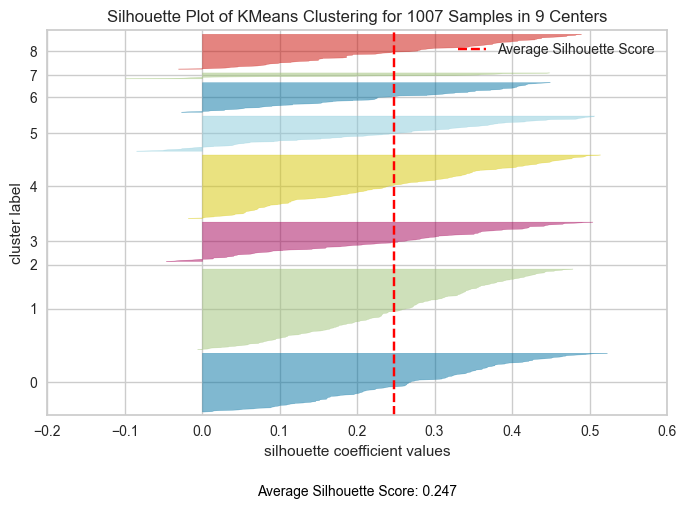

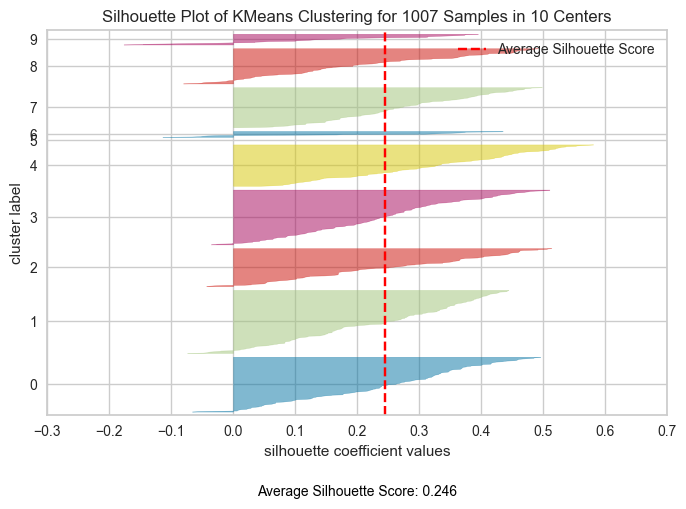

In [52]:
silhouette_scores = []  # Lista per salvare i punteggi della silhouette

# Ciclo per applicare KMeans con diversi numeri di cluster e calcolare la silhouette score
for n_clusters in range(2, 11):
    # Crea un'istanza di KMeans
    kmeans = KMeans(n_clusters=n_clusters, init='k-means++', n_init=10, max_iter=300, random_state=42)
    
    # Crea il visualizzatore di silhouette
    fig, ax = plt.subplots(figsize=(8, 5))  # Definisci la grandezza del grafico
    visualizer = SilhouetteVisualizer(kmeans, colors='yellowbrick', ax=ax)
    visualizer.fit(scaled_features)
    
    # Aggiungi il valore della silhouette score sotto l'asse delle ascisse
    avg_silhouette_score = visualizer.silhouette_score_  # Ottieni il valore medio della silhouette score
    silhouette_scores.append(avg_silhouette_score)
    
    # Aggiungi il valore della silhouette score sotto il grafico
    ax.text(0.5, -0.2, f'Average Silhouette Score: {avg_silhouette_score:.3f}', 
            transform=ax.transAxes, ha='center', va='center', fontsize=10, color='black')

    # Mostra il grafico
    visualizer.show()

plt.show()

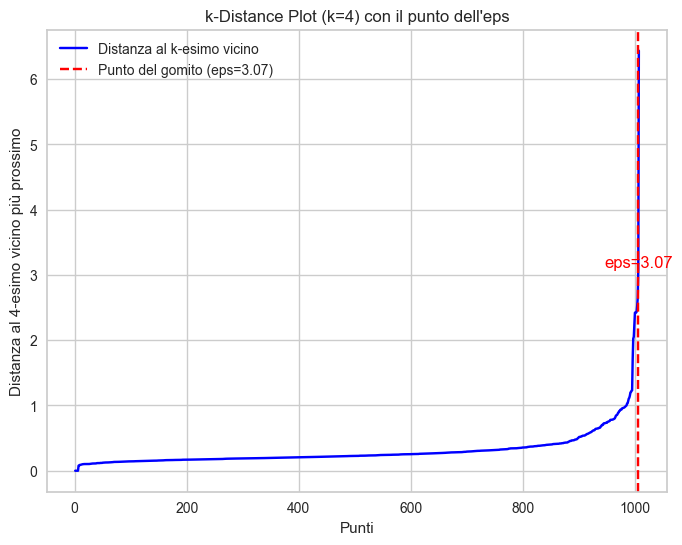

In [53]:
# Definisci il valore di k (numero di vicini)
k = 4  # Puoi cambiare questo valore in base alle tue necessità

# Calcolare le distanze dai vicini più prossimi
neigh = NearestNeighbors(n_neighbors=k)
neigh.fit(scaled_features)
distances, indices = neigh.kneighbors(scaled_features)

# La distanza al k-esimo vicino per ogni punto (prendiamo la k-esima distanza da ogni punto)
k_distances = distances[:, -1]  # L'ultima colonna corrisponde alla k-esima distanza

# Ordinare le distanze in ordine crescente
k_distances = np.sort(k_distances)

# Calcolare la derivata per trovare il punto di massima variazione
derivative = np.diff(k_distances)  # Differenza tra distanze successive
# Trova il punto in cui la derivata è massima (punto di gomito)
elbow_index = np.argmax(derivative)

# Tracciare il k-distance plot
plt.figure(figsize=(8, 6))
plt.plot(np.arange(1, len(k_distances) + 1), k_distances, label='Distanza al k-esimo vicino', color='blue')

# Aggiungere il punto del gomito (dove la derivata è massima)
plt.axvline(x=elbow_index + 1, color='red', linestyle='--', label=f'Punto del gomito (eps={k_distances[elbow_index]:.2f})')

# Aggiungere un'etichetta al punto
plt.text(elbow_index + 1, k_distances[elbow_index] + 0.05, f'eps={k_distances[elbow_index]:.2f}', 
         color='red', fontsize=12, ha='center')

# Titolo e etichette
plt.title(f"k-Distance Plot (k={k}) con il punto dell'eps")
plt.xlabel("Punti")
plt.ylabel(f"Distanza al {k}-esimo vicino più prossimo")
plt.grid(True)
plt.legend()
plt.show()

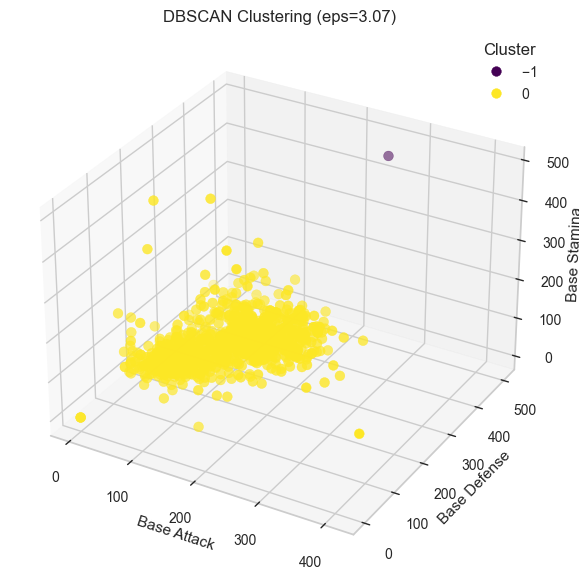

In [54]:
# Esegui DBSCAN con l'eps trovato
eps = k_distances[elbow_index]  # Usa il valore di eps trovato nel k-distance plot
dbscan = DBSCAN(eps=eps, min_samples=k)
labels = dbscan.fit_predict(scaled_features)

# Visualizzare il clustering in 3D
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Tracciare i punti nel grafico 3D, colorati in base al cluster
# Gestisci i punti rumore (-1) separatamente
scatter = ax.scatter(pokemon["base_attack"], pokemon["base_defense"], pokemon["base_stamina"], c=labels, cmap='viridis', s=50)

# Aggiungere etichette e titolo
ax.set_xlabel("Base Attack")
ax.set_ylabel("Base Defense")
ax.set_zlabel("Base Stamina")
ax.set_title(f"DBSCAN Clustering (eps={eps:.2f})")

# Aggiungere la legenda
plt.legend(*scatter.legend_elements(), title="Cluster")
plt.show()

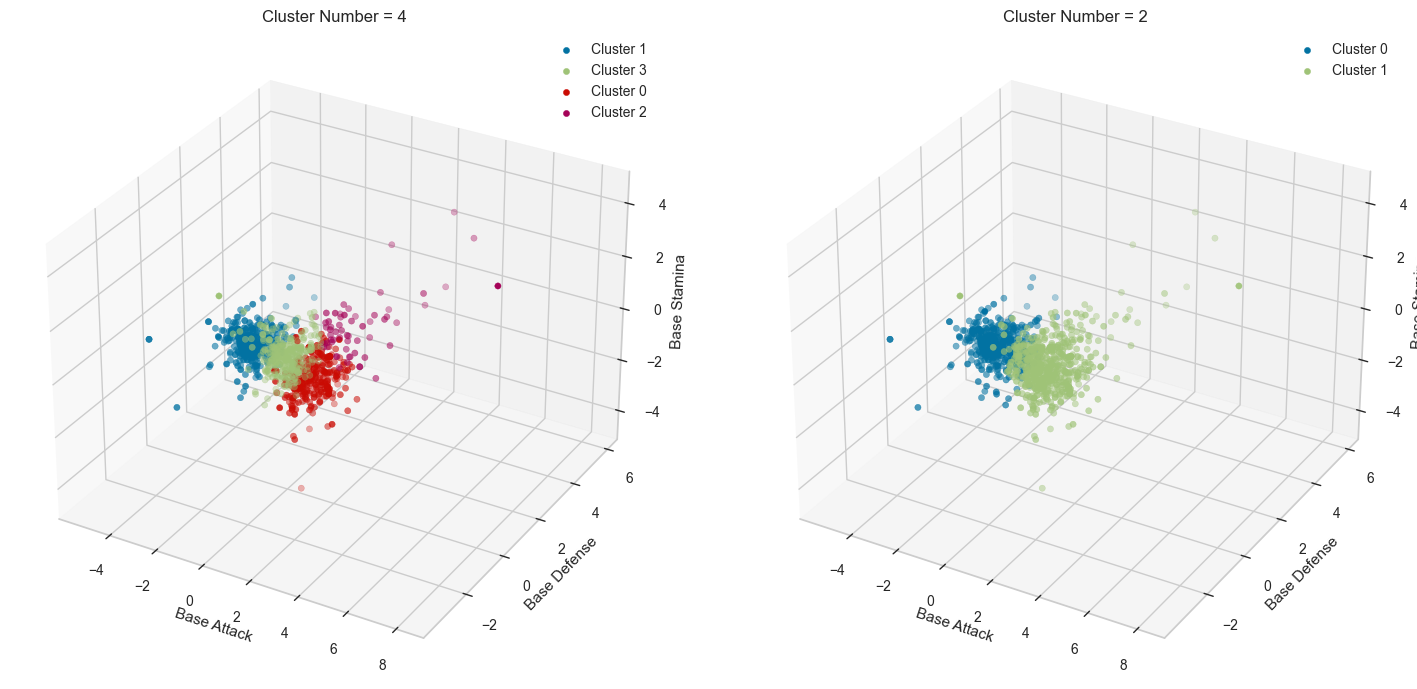

In [55]:
cluster_values = [4, 2]

# Create subplots for 3D plotting
fig = plt.figure(figsize=(15, 7))

# Iterate over each number of clusters
for i, n_clusters in enumerate(cluster_values):
    # Initialize KMeans with specified number of clusters
    kmeans = KMeans(n_clusters=n_clusters, init='k-means++', max_iter=300, n_init=10, random_state=42)
    kmeans.fit(scaled_features)

    # Assign cluster labels to the original dataset
    pokemon['cluster'] = kmeans.labels_

    # Apply PCA for dimensionality reduction to 3 components
    pca = PCA(n_components=3)
    principal_components = pca.fit_transform(scaled_features)

    # Create a DataFrame with the principal components and cluster labels
    pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2', 'PC3'])
    pca_df['cluster'] = pokemon['cluster']  # Adding cluster labels

    # Create a 3D plot
    ax = fig.add_subplot(1, len(cluster_values), i+1, projection='3d')

    # Plot clusters in 3D
    for cluster in pca_df['cluster'].unique():
        cluster_data = pca_df[pca_df['cluster'] == cluster]
        ax.scatter(cluster_data['PC1'], cluster_data['PC2'], cluster_data['PC3'], label=f'Cluster {cluster}')

    ax.set_title(f'Cluster Number = {n_clusters}')
    # Aggiungere etichette e titolo
    ax.set_xlabel("Base Attack")
    ax.set_ylabel("Base Defense")
    ax.set_zlabel("Base Stamina")
    ax.legend()

plt.tight_layout()
plt.show()

C:\Users\gabri\AppData\Local\Temp\ipykernel_24596\2402451686.py:33: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




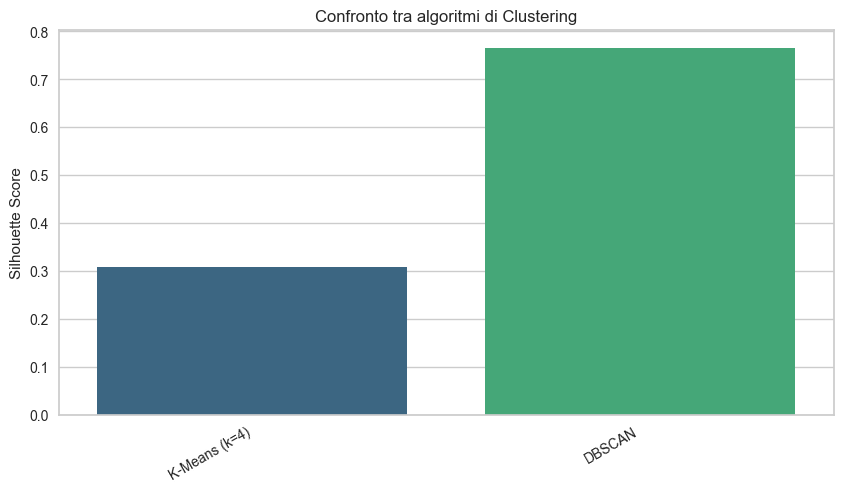

K-Means (k=4): 0.3076740999755922
DBSCAN: 0.7653640328312495


In [ ]:
# Preprocessing: rimuovere i NaN
pokemon[selected_features] = pokemon[selected_features].fillna(pokemon[selected_features].mean())

# Standardizzazione delle feature
scaler = StandardScaler()
scaled_features = scaler.fit_transform(pokemon[selected_features])

# Creiamo una lista di algoritmi di clustering da testare
clustering_algorithms = {
    "K-Means (k=4)": KMeans(n_clusters=4, init='k-means++', n_init=10, random_state=42),
    "DBSCAN": DBSCAN(eps=3.05, min_samples=5),  # eps può essere ottimizzato
}

# Dizionario per salvare i risultati
silhouette_scores = {}

# Applichiamo ogni algoritmo e calcoliamo lo score della silhouette
for name, model in clustering_algorithms.items():
    if isinstance(model, GaussianMixture):
        cluster_labels = model.fit_predict(scaled_features)
    else:
        cluster_labels = model.fit_predict(scaled_features)

    # Calcoliamo lo score solo se il numero di cluster è maggiore di 1
    if len(set(cluster_labels)) > 1:
        silhouette_avg = silhouette_score(scaled_features, cluster_labels)
        silhouette_scores[name] = silhouette_avg
    else:
        silhouette_scores[name] = "N/A"  # Se c'è un solo cluster, la silhouette non è valida

# Visualizziamo i risultati
plt.figure(figsize=(10, 5))
sns.barplot(x=list(silhouette_scores.keys()), y=[s for s in silhouette_scores.values() if s != "N/A"], palette="viridis")
plt.xticks(rotation=30, ha='right')
plt.ylabel("Silhouette Score")
plt.title("Confronto tra algoritmi di Clustering")
plt.show()

# Stampa dei risultati
for name, score in silhouette_scores.items():
    print(f"{name}: {score}")